### Modules

In [3]:
# -
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import SubplotSpec
import h5py as h5
import tarfile
import cmasher as cmr
import rapid_code_load_T0 as load
import formation_channels as fc
from rapid_code_load_T0 import load_BSE_data, convert_COMPAS_data_to_TO, load_COSMIC_data, load_SeBa_data, load_T0_data
# -

### Open Data Files

In [4]:
#COMPAS = '/Users/sarahpelesky/Library/Mobile Documents/com~apple~CloudDocs/CMU Files/Semester 7 (Fall 2024)/Breivik Research/COMPAS_pilot.h5'
#co = convert_COMPAS_data_to_TO(COMPAS)

COSMIC = '/Users/sarahpelesky/Library/Mobile Documents/com~apple~CloudDocs/CMU Files/Semester 7 (Fall 2024)/Breivik Research/basic.h5'
c, c_header = load_COSMIC_data(COSMIC, metallicity=0.02)

METISSE = '/Users/sarahpelesky/Library/Mobile Documents/com~apple~CloudDocs/CMU Files/Semester 7 (Fall 2024)/Breivik Research/basic_METISSE.h5'
m, m_header = load_COSMIC_data(METISSE, metallicity=0.02)

SEVN_mist = '/Users/sarahpelesky/Library/Mobile Documents/com~apple~CloudDocs/CMU Files/Semester 7 (Fall 2024)/Breivik Research/sevn_mist'
sm, sm_header = load_T0_data(SEVN_mist, code='SEVN', metallicity=0.02)

#### Mass 1 vs. Orbital Period Function

In [57]:
from re import S
def get_first_RLO_figure(d, q=0.49, savefig=None):
    ZAMS, WDMS, DWD = fc.select_evolutionary_states(d=d)
    #channels = fc.select_channels(d=d)

    ZAMS['porb'] = ((ZAMS.semiMajor / 215.032)**3 / (ZAMS.mass1+ZAMS.mass2))**0.5 * 365.25
    WDMS['porb'] = ((WDMS.semiMajor / 215.032)**3 / (WDMS.mass1+WDMS.mass2))**0.5 * 365.25
    DWD['porb'] = ((DWD.semiMajor / 215.032)**3 / (DWD.mass1+DWD.mass2))**0.5 * 365.25
    first_RLO = fc.first_interaction_channels(d=d)

    init_q = ZAMS.loc[(np.round(ZAMS.mass2/ZAMS.mass1, 2) == q)]

    #check that all IDs are accounted for:
    all_IDs = d.ID.unique()
    keys = ['SMT_1', 'SMT_2', 'CE_1', 'CE_2', 'DCCE', 'merger', 'nonRLO']
    id_check = []
    for k in keys:
        id_check.extend(first_RLO[k])
    if len(np.setxor1d(all_IDs, id_check)) > 0:
        print("waning, you missed ids:", np.setxor1d(all_IDS, id_check))

    SMT_colors = cmr.take_cmap_colors('cmr.sapphire', 2, cmap_range=(0.4, 0.85), return_fmt='hex')
    CE_colors = cmr.take_cmap_colors('cmr.sunburst', 3, cmap_range=(0.3, 0.9), return_fmt='hex')
    other_colors = cmr.take_cmap_colors('cmr.neutral', 2, cmap_range=(0.35, 0.85), return_fmt='hex')

    keys_list = [['SMT_1', 'SMT_2'], ['CE_1', 'CE_2', 'DCCE'], ['merger', 'nonRLO']]
    colors_list = [SMT_colors, CE_colors, other_colors]
    listMaking(colors_list, keys_list, init_q, first_RLO, all_IDs, d)
    plt.figure(figsize=(6,4.8))
    for colors, keys in zip(colors_list, keys_list):
        for c, k, ii in zip(colors, keys, range(len(colors))):
            ZAMS_select = init_q.loc[(init_q.ID.isin(first_RLO[k]))]
            if len(ZAMS_select) > 0:
                #if k != 'failed_CE':
                print(len(ZAMS_select), k)
                plt.scatter(ZAMS_select.porb, ZAMS_select.mass1, c=c, s=5.8, label=k, zorder=200 - (1+ii)*5, marker='s')
            else:
                print(0, k)
    print()
    print()
    plt.xscale('log')
    plt.legend(loc=(0.0, 1.01), ncol=3, prop={'size':9})
    plt.yscale('log')
    plt.xlim(min(init_q.porb)-0.1, max(init_q.porb))
    plt.ylim(min(init_q.mass1)-0.05, max(init_q.mass1)+0.5)

    plt.xlabel('orbital period [day]')
    plt.ylabel('M$_1$ [Msun]')
    if savefig != None:
        plt.tight_layout()
        plt.savefig(savefig, dpi=100, facecolor='white')
    plt.show()

    return first_RLO



#### Filtering to Find Outliers Functions

In [73]:
def listMaking(colors_list, keys_list, init_q, first_RLO, all_IDs, d):
  SMT_1_porb = []
  SMT_1_M1 = []
  CE_1_porb = []
  CE_1_M1 = []
  SMT_1_ID = []
  CE_1_ID = []
  for colors, keys in zip(colors_list, keys_list):
    for c, k, ii in zip(colors, keys, range(len(colors))):
      ZAMS_select = init_q.loc[(init_q.ID.isin(first_RLO[k]))]
      if k == 'SMT_1':
        for s in range(len(ZAMS_select)):
          SMT_1_porb.append(ZAMS_select.porb.iloc[s])
          SMT_1_M1.append(ZAMS_select.mass1.iloc[s])
          SMT_1_ID.append(ZAMS_select.ID.iloc[s])
      if k == 'CE_1':
        for s in range(len(ZAMS_select)):
          CE_1_porb.append(ZAMS_select.porb.iloc[s])
          CE_1_M1.append(ZAMS_select.mass1.iloc[s])
          CE_1_ID.append(ZAMS_select.ID.iloc[s])
  outliers(SMT_1_porb, SMT_1_M1, SMT_1_ID, CE_1_porb, CE_1_M1, CE_1_ID)

In [127]:
def outliers(SMT_1_porb, SMT_1_M1, SMT_1_ID, CE_1_porb, CE_1_M1, CE_1_ID):
  p = np.logspace(0, 3.5, len(SMT_1_porb))
  min_SMT_1_mass1 = []
  porb = []
  CE_1_outliers = []
  porb1 = []
  CE_ID_outliers = []
  for i in range(len(SMT_1_porb)):
    p_min = p[i] - 0.45
    p_max = p[i] + 0.45
    min_SMT_1_mass1_temp = []
    for k in range(len(SMT_1_porb)):
      if p_min < SMT_1_porb[k] < p_max:
        min_SMT_1_mass1_temp.append(SMT_1_M1[k])
    if len(min_SMT_1_mass1_temp) > 0:
      min_SMT_1_mass1.append(min(min_SMT_1_mass1_temp))
      porb.append(p[i])
      CE_1_mass_temp = []
      CE_ID_temp = []
      for j in range(len(CE_1_porb)):
        if p_min < CE_1_porb[j] < p_max:
          CE_1_mass_temp.append(CE_1_M1[j])
          CE_ID_temp.append(CE_1_ID[j])
      if len(CE_1_mass_temp) > 0:
        if p_min < p[i] < p_max:
          for l in range(len(CE_1_mass_temp)):
            if CE_1_mass_temp[l] > min(min_SMT_1_mass1_temp) and CE_ID_temp[l] not in CE_ID_outliers:
              CE_1_outliers.append(CE_1_mass_temp[l])
              porb1.append(p[i])
              CE_ID_outliers.append(CE_ID_temp[l])

  plt.scatter(porb, min_SMT_1_mass1, s = 5)
  CE_IDs = []
  for i in range(len(porb1)):
    if CE_1_outliers[i] > 10**0.5 and porb1[i] < 10**2.5:
      plt.scatter(porb1[i], CE_1_outliers[i], s = 5, c='red')
      CE_IDs.append(CE_ID_outliers[i])
  print(len(CE_IDs))
  plt.xscale('log')
  plt.yscale('log')
  plt.xlim(10**0, 10**4)
  plt.xlabel('orbital period [day]')
  plt.ylabel('M$_1$ [Msun]')
  plt.show()

#### Plotting functions

477099
14


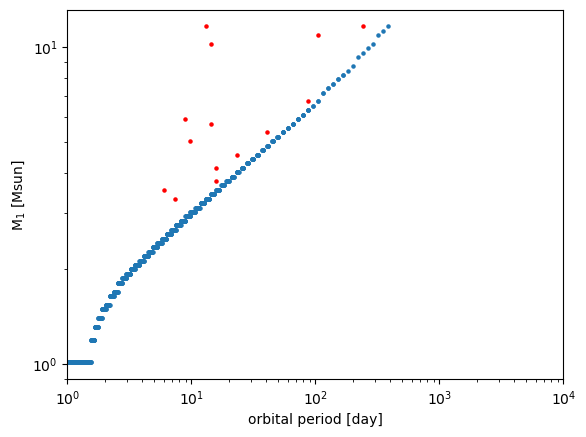

2424 SMT_1
0 SMT_2
3499 CE_1
0 CE_2
0 DCCE
0 merger
1877 nonRLO




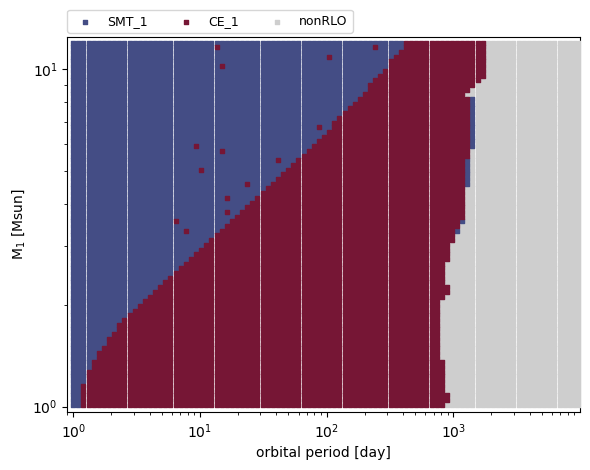

477099
18


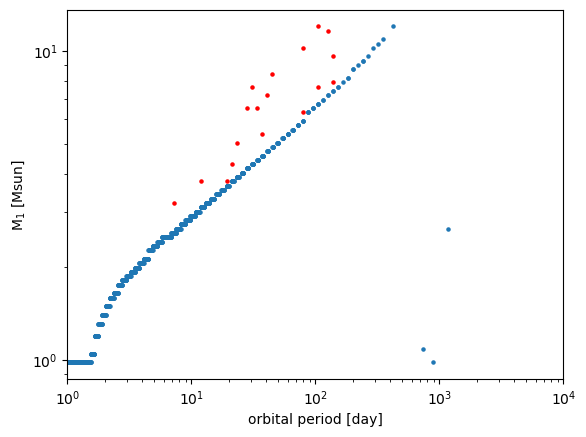

2633 SMT_1
0 SMT_2
3590 CE_1
2 CE_2
0 DCCE
0 merger
1975 nonRLO




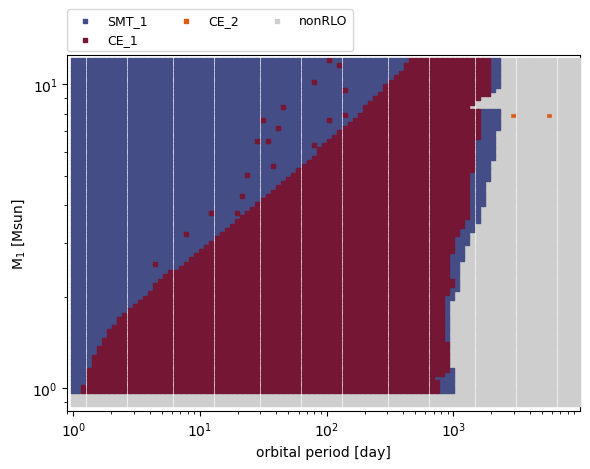

In [128]:
first_RLO_c_05 = get_first_RLO_figure(d=c, q=0.49, savefig='first_RLO_COSMIC_pilot_qinit05.png')

first_RLO_c09 = get_first_RLO_figure(d=c, q=0.88, savefig='first_RLO_COSMIC_pilot_qinit09.png')

In [22]:
#first_RLO_co_05 = get_first_RLO_figure(d=co, q=0.49, savefig='first_RLO_COMPAS_pilot_qinit05.png')

#first_RLO_co_09 = get_first_RLO_figure(d=co, q=0.88, savefig='first_RLO_COMPAS_pilot_qinit09.png')

477099
801


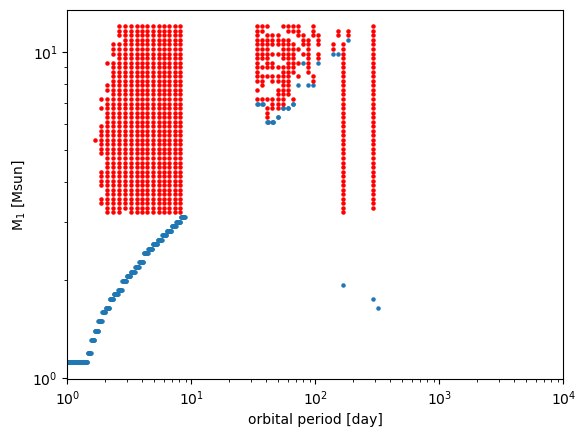

880 SMT_1
0 SMT_2
4347 CE_1
0 CE_2
0 DCCE
0 merger
2573 nonRLO




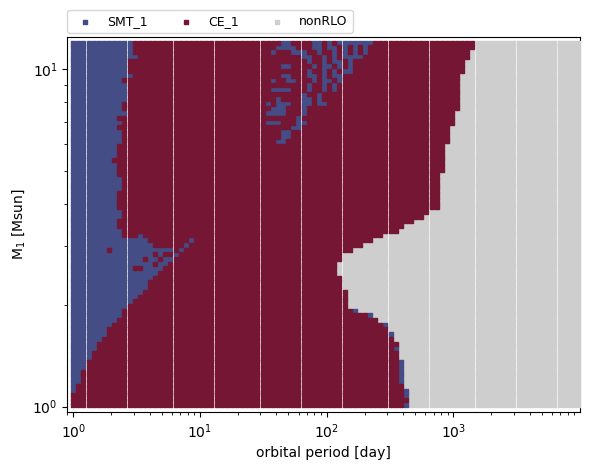

477099
201


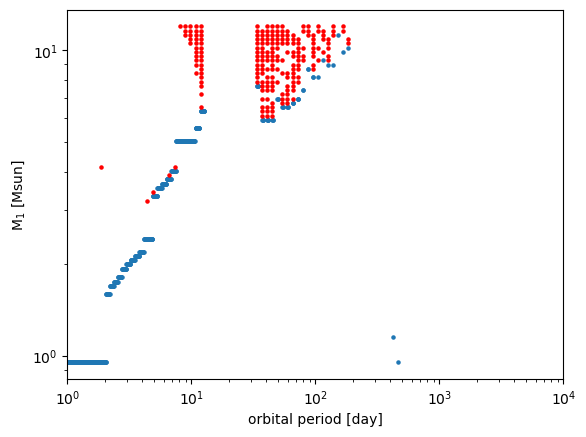

1470 SMT_1
0 SMT_2
3940 CE_1
12 CE_2
0 DCCE
1 merger
2777 nonRLO




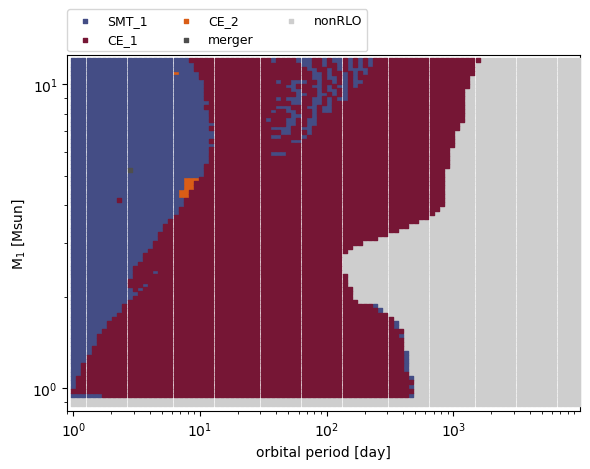

In [129]:
first_RLO_m_05 = get_first_RLO_figure(d=m, q=0.49, savefig='first_RLO_METISSE_pilot_qinit05.png')

first_RLO_m_09 = get_first_RLO_figure(d=m, q=0.88, savefig='first_RLO_METISSE_pilot_qinit09.png')